### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [65]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [66]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [67]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-11-06 07:05:40--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.4’

onegin.txt.4        100%[===================>] 256.37K  --.-KB/s    in 0.004s  

2024-11-06 07:05:40 (61.6 MB/s) - ‘onegin.txt.4’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [68]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [69]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [70]:
next(generate_chunk())

array([[83, 45, 56, ..., 48, 59, 47],
       [83, 59, 61, ...,  1, 62, 60],
       [83, 53, 62, ...,  1, 60, 53],
       ...,
       [83, 61, 55, ...,  1, 62, 59],
       [83, 48, 56, ..., 57,  1, 52],
       [83, 50, 61, ..., 59, 56, 59]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [71]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, nonlinearity='tanh', batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

In [72]:
input_size = num_tokens  # Размер входного пространства (количество токенов)
hidden_size = 128        # Размер скрытого слоя
output_size = num_tokens # Размер выходного пространства (количество токенов)
num_layers = 2           # Количество слоев RNN
num_epochs = 200         # Количество эпох обучения
learning_rate = 0.003    # Скорость обучения
batch_size = 256         # Размер батча
seq_length = 100         # Длина последовательности

model = VanillaRNN(input_size, hidden_size, output_size, num_layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [73]:
def one_hot_encode(batch, num_tokens):
    return F.one_hot(torch.tensor(batch[:, :-1]), num_classes=num_tokens).float()

def get_targets(batch):
    return torch.tensor(batch[:, 1:]).reshape(-1).to(device)

batches_per_epoch = len(text_encoded) // (batch_size * seq_length)

In [74]:
loss_history = []

for epoch in range(1, num_epochs + 1):
    model.train()
    hidden = model.init_hidden(batch_size)
    total_loss = 0.0

    for _ in range(batches_per_epoch):
        batch = next(generate_chunk())
        inputs = one_hot_encode(batch, num_tokens).to(device)
        targets = get_targets(batch)

        optimizer.zero_grad()

        outputs, hidden = model(inputs, hidden.detach())

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / batches_per_epoch
    loss_history.append(avg_loss)
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/200], Loss: 3.9410
Epoch [2/200], Loss: 3.3692
Epoch [3/200], Loss: 3.3320
Epoch [4/200], Loss: 3.3272
Epoch [5/200], Loss: 3.3155
Epoch [6/200], Loss: 3.3139
Epoch [7/200], Loss: 3.3009
Epoch [8/200], Loss: 3.2922
Epoch [9/200], Loss: 3.2734
Epoch [10/200], Loss: 3.2300
Epoch [11/200], Loss: 3.1948
Epoch [12/200], Loss: 3.1576
Epoch [13/200], Loss: 3.1010
Epoch [14/200], Loss: 3.0487
Epoch [15/200], Loss: 3.0085
Epoch [16/200], Loss: 2.9601
Epoch [17/200], Loss: 2.9205
Epoch [18/200], Loss: 2.8878
Epoch [19/200], Loss: 2.8763
Epoch [20/200], Loss: 2.8449
Epoch [21/200], Loss: 2.8070
Epoch [22/200], Loss: 2.7853
Epoch [23/200], Loss: 2.7546
Epoch [24/200], Loss: 2.7373
Epoch [25/200], Loss: 2.7078
Epoch [26/200], Loss: 2.6970
Epoch [27/200], Loss: 2.6764
Epoch [28/200], Loss: 2.6526
Epoch [29/200], Loss: 2.6386
Epoch [30/200], Loss: 2.6172
Epoch [31/200], Loss: 2.5990
Epoch [32/200], Loss: 2.5883
Epoch [33/200], Loss: 2.5756
Epoch [34/200], Loss: 2.5611
Epoch [35/200], Loss: 2

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

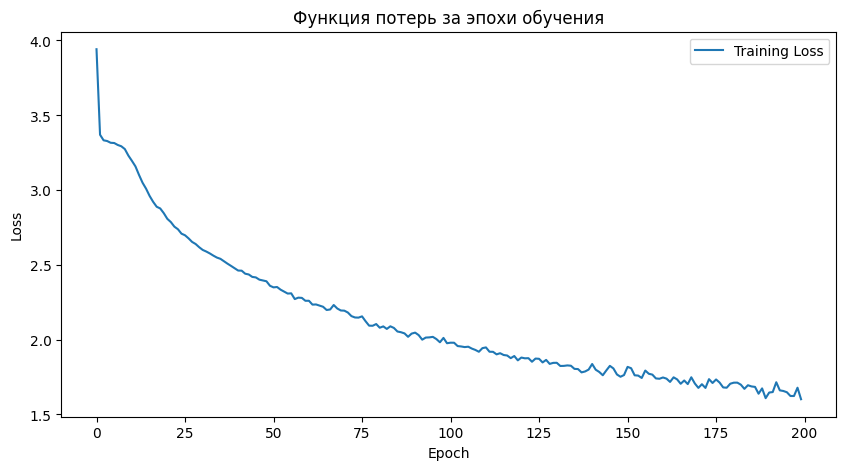

In [75]:
plt.figure(figsize=(10,5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Функция потерь за эпохи обучения')
plt.legend()
plt.show()

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [76]:
def generate_sample(char_rnn, seed_phrase=None, max_length=500, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, excluding the seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    input_seq = F.one_hot(x_sequence, num_classes=num_tokens).float()

    hidden = char_rnn.init_hidden(1)
    generated = x_sequence.tolist()[0]

    for _ in range(max_length):
        output, hidden = char_rnn(input_seq, hidden)
        output = output / temperature
        probabilities = F.softmax(output, dim=1).data
        probabilities = probabilities.cpu()
        top_i = torch.multinomial(probabilities, 1)[-1]
        generated.append(top_i.item())
        input_seq = F.one_hot(torch.tensor([[top_i]]), num_classes=num_tokens).float().to(device)

    return ''.join([idx_to_token[ix] for ix in generated[1:]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [77]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

 мой дядя самых честных правил
на правлять моемит так;
всегда бы видил родую
открыльною своих стирит
сосед в берем были болов,
в темны как нет ине идета любви,
но ворой дорговомит,
но в нем песьмой для страсти.



xxi

всё это дреги поядать,
оти был льютя наши нровым,
с ониковые привела:
во я благосельца и постал
истредах нас сомник милая,
пора двере семьем он весела.
не знала ждов его старины,
он встретел и что ж? бывлять.



xxxviii

одно благодостно в луна!



xxiii

мое! ны льби, качтольки приезданья,
с ивгоря не благосо


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [78]:
seed_phrase = ' мой дядя самых честных правил'

In [79]:
desired_total_length = 500
additional_length = desired_total_length - len(seed_phrase)

generated_phrases = [
    generate_sample(
        model,
        seed_phrase,
        max_length=additional_length,
        temperature=0.8
    )
    for _ in range(10)
]

In [80]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!